<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/02_pytorch_classification_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steel Plate Prediction
[Kaggle links](https://www.kaggle.com/competitions/playground-series-s4e3/overview)

## Tech
* XGBoost + LGBM Ensemble


In [1]:
!pip install shap
!pip install sweetviz

#EDA Tool
import sweetviz as sv
#from ydata_profiling import ProfileReport

#Classic
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as ltb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
#import lime
#from lime import lime_tabular

#MLops
#import mlflow
#from mlflow.tracking import MlflowClient
#from mlflow.models import infer_signature
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.early_stop import no_progress_loss
#import optuna
#from optuna.samplers import TPESampler
#from autogluon.tabular import TabularDataset, TabularPredictor
#from lazypredict.Supervised import LazyClassifier,LazyRegressor

#Sklearn
from sklearn.model_selection import train_test_split,RepeatedKFold,KFold,StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler,OneHotEncoder,MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix,mean_squared_error,r2_score,classification_report,ConfusionMatrixDisplay, log_loss,mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 59.7 MB/s eta 0:00:00


In [2]:
#Import Dataset

from google.colab import files
uploaded = files.upload()


Saving sample_submission.csv to sample_submission.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
# Turn data into a DataFrame
df = pd.read_csv(r'train.csv')
Real_test = pd.read_csv(r'test.csv')
test = Real_test.drop('id',axis = 1)
print(df)


          id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0          0        584        590     909972     909977            16   
1          1        808        816     728350     728372           433   
2          2         39        192    2212076    2212144         11388   
3          3        781        789    3353146    3353173           210   
4          4       1540       1560     618457     618502           521   
...      ...        ...        ...        ...        ...           ...   
19214  19214        749        757     143210     143219            17   
19215  19215        723        735    2488529    2488541           231   
19216  19216          6         31    1578055    1578129           780   
19217  19217          9         18    1713172    1713184           126   
19218  19218       1505       1525    1733458    1733471           182   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0                8            5   

In [4]:
"""# Visualize the data
#EDA Exploratory data analysis
analyze_report = sv.analyze(df)
analyze_report.show_html()
"""
"""
profile = ProfileReport(df, title="Profiling Report")
profile.to_file("Test_report.html")
"""

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


'\nprofile = ProfileReport(df, title="Profiling Report")\nprofile.to_file("Test_report.html")\n'

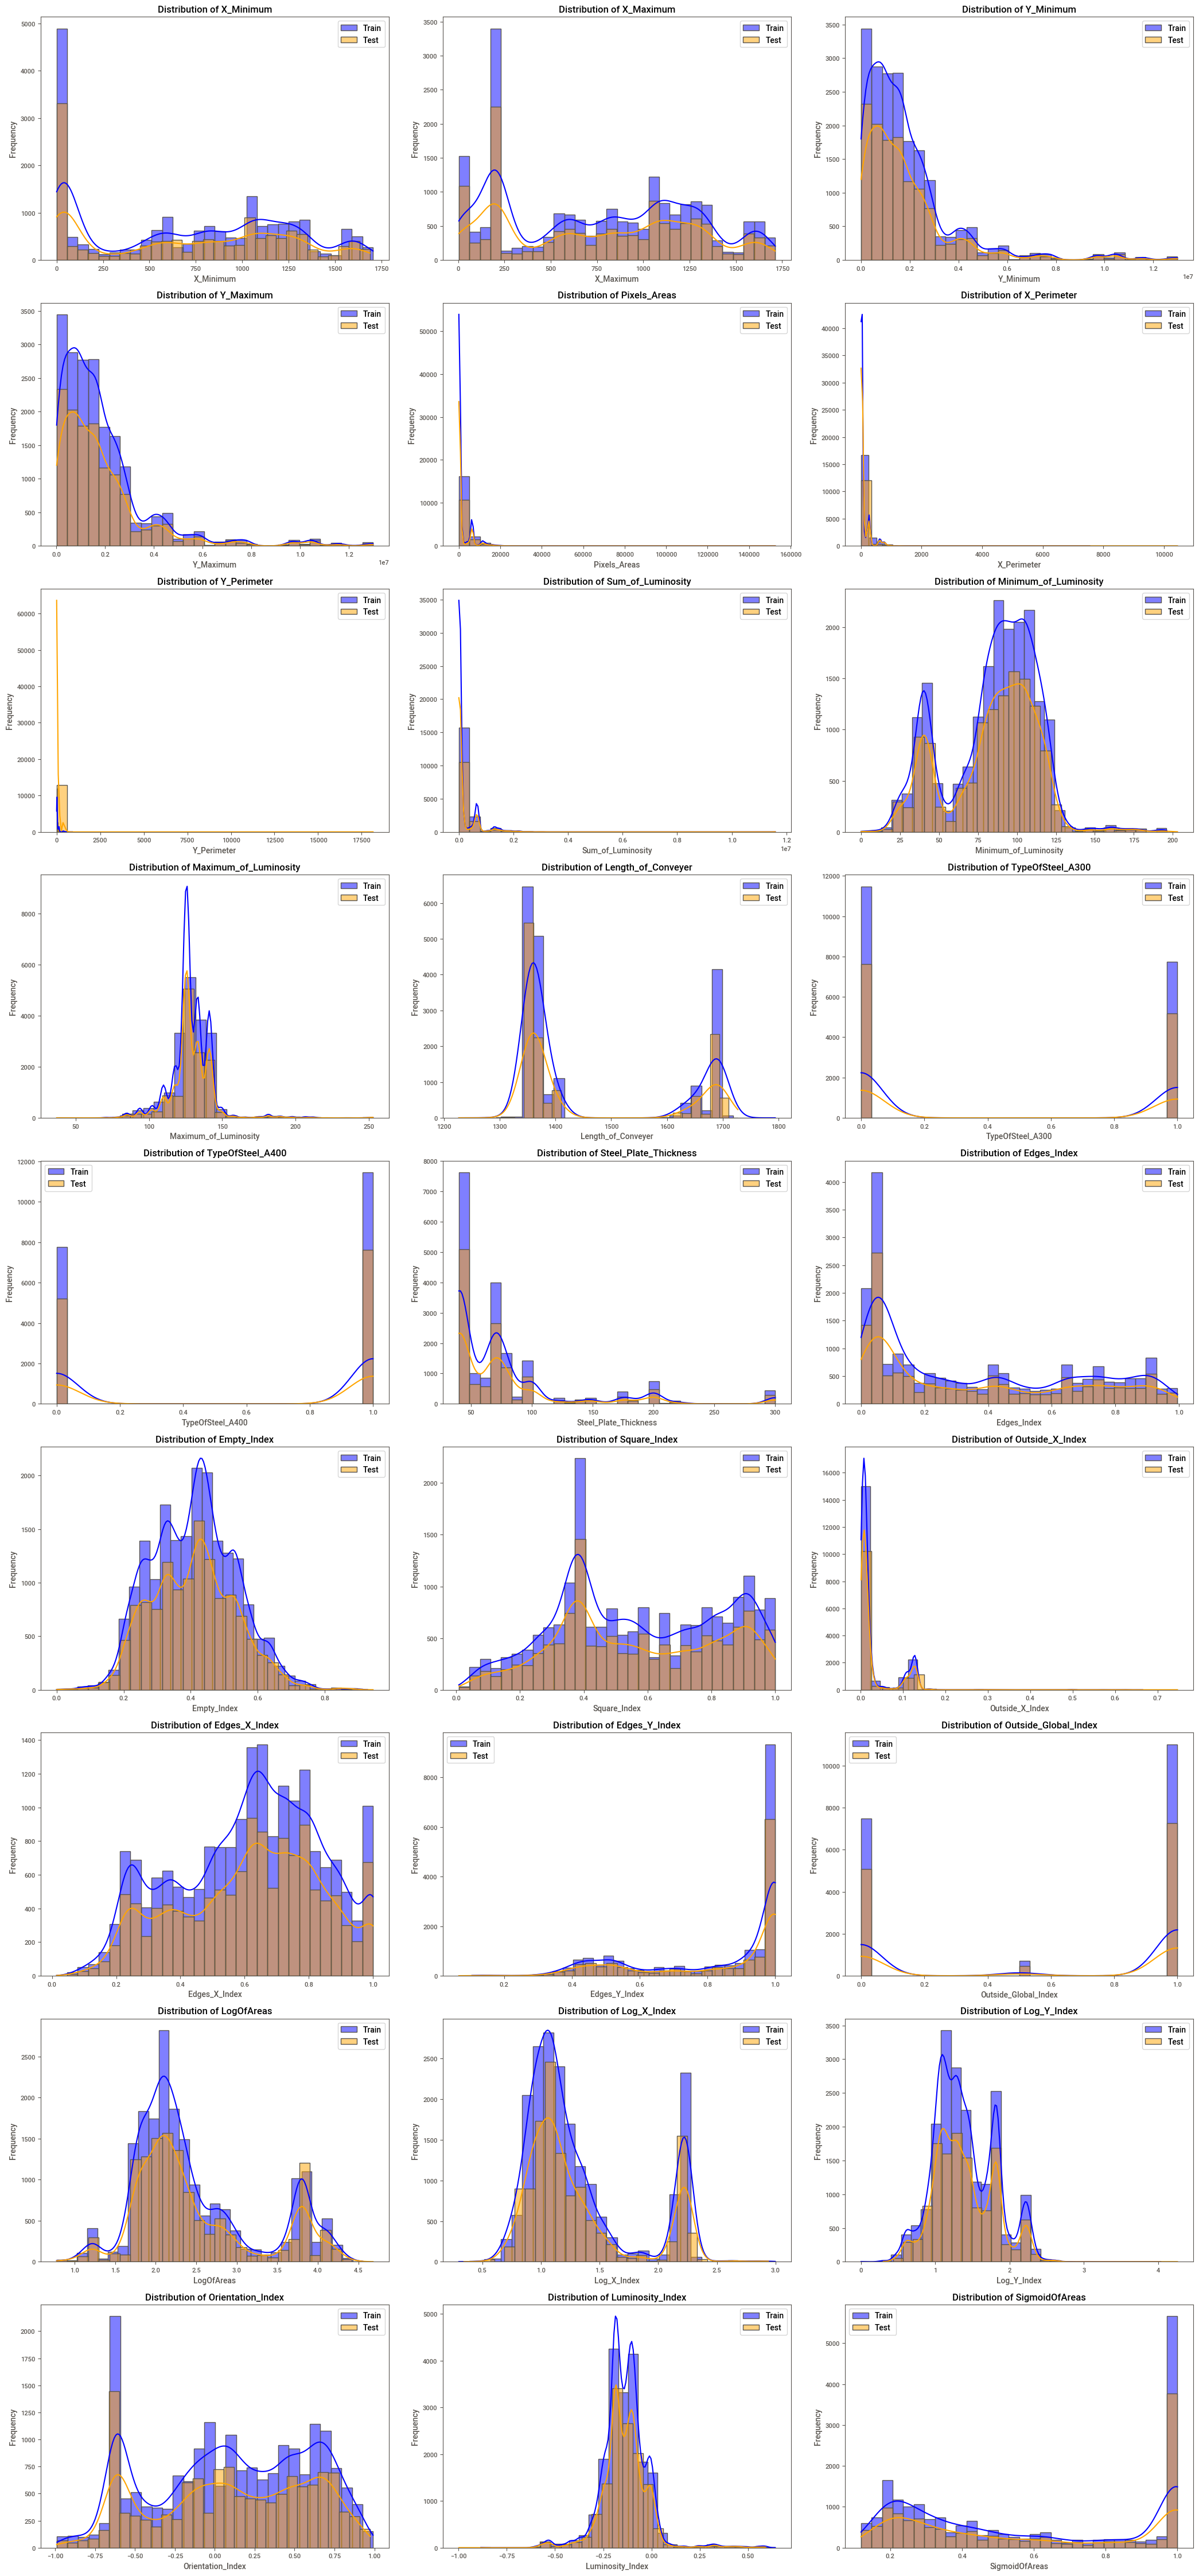

In [5]:

# Numerical Feature Distributions
cont_cols = test.columns
colors = ['blue', 'orange', 'green']

num_plots = len(cont_cols)
num_cols = 3
num_rows = -(-num_plots // num_cols)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 5 * num_rows))  # Adjust the figure size as needed

for i, feature in enumerate(cont_cols):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col] if num_rows > 1 else axes[col]

    sns.histplot(df[feature], kde=True, color=colors[0], label='Train', alpha=0.5, bins=30, ax=ax)
    sns.histplot(test[feature], kde=True, color=colors[1], label='Test', alpha=0.5, bins=30, ax=ax)

    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

if num_plots % num_cols != 0:
    for j in range(num_plots % num_cols, num_cols):
        axes[-1, j].axis('off')

plt.tight_layout()
plt.show()



In [6]:
#Feature engineering
df['X_Range'] = df['X_Maximum'] - df['X_Minimum']
df['Y_Range'] = df['Y_Maximum'] - df['Y_Minimum']
df['Luminosity_Diff'] = df['Maximum_of_Luminosity'] - df['Minimum_of_Luminosity']

test['X_Range'] = test['X_Maximum'] - test['X_Minimum']
test['Y_Range'] = test['Y_Maximum'] - test['Y_Minimum']
test['Luminosity_Diff'] = test['Maximum_of_Luminosity'] - test['Minimum_of_Luminosity']
print(df)


          id  X_Minimum  X_Maximum  Y_Minimum  Y_Maximum  Pixels_Areas  \
0          0        584        590     909972     909977            16   
1          1        808        816     728350     728372           433   
2          2         39        192    2212076    2212144         11388   
3          3        781        789    3353146    3353173           210   
4          4       1540       1560     618457     618502           521   
...      ...        ...        ...        ...        ...           ...   
19214  19214        749        757     143210     143219            17   
19215  19215        723        735    2488529    2488541           231   
19216  19216          6         31    1578055    1578129           780   
19217  19217          9         18    1713172    1713184           126   
19218  19218       1505       1525    1733458    1733471           182   

       X_Perimeter  Y_Perimeter  Sum_of_Luminosity  Minimum_of_Luminosity  \
0                8            5   

In [7]:
#PREDICTION
start_list = []
tab = pd.DataFrame()
TARGET = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']
#TARGET = ['Pastry']
for item in TARGET:
    print(item)
    FEATURES = [col for col in df.columns if col not in ['id', 'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]

    #Standardisation/Normalisation
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    #df[FEATURES]= scaler.fit_transform(df[FEATURES])



    y = df[item]
    X = df[FEATURES]



    # Classic Train-test split
    #X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    """df_Gluon_train=pd.concat([X_train,y_train],axis=1)
    df_Gluon_test=pd.concat([X_valid,y_valid],axis=1)
    """
    """# Select categorical columns with relatively low cardinality (convenient but arbitrary)
    categorical_cols = [cname for cname in X_train.columns if X_train[cname].nunique() < 10 and
                            X_train[cname].dtype == "object"]

    # Select numerical columns
    numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]"""


    """# Keep selected columns only
    my_cols = categorical_cols + numerical_cols
    X_train = X_train[my_cols].copy()
    X_valid = X_valid[my_cols].copy()


    # Preprocessing for numerical data
    numerical_transformer = SimpleImputer(strategy='mean')

    # Preprocessing for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    """

    """#Best ML models whitout hyperparameters tunning
    reg = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=roc_auc_score)
    models, predictions = reg.fit(X_train, X_valid, y_train, y_valid)
    print(models)
    """
    """#Autogluon
    label= item
    train_data = TabularDataset(df_Gluon_train)
    predictor = TabularPredictor(label=item,eval_metric="roc_auc").fit(train_data)
    #predictor = TabularPredictor(label=item,eval_metric="roc_auc").fit(train_data)
    test_data = TabularDataset(df_Gluon_test)
    board=predictor.leaderboard(test_data)
    print(board)
    #predictor.evaluate(test_data, silent=True)

    real_test_data = TabularDataset(test)
    y_pred = predictor.predict_proba(real_test_data)
    perf = predictor.evaluate(test_data, auxiliary_metrics=False)
    print(perf)"""

    """
    #Load Autogluon model
    model_savepath = "AutogluonModels/"+str(item)
    model = TabularPredictor.load(model_savepath, require_version_match=False, verbosity=4)
    real_test_data = TabularDataset(test)
    y_pred = model.predict_proba(real_test_data)
    print(y_pred)
    #y_pred = predictor.predict(test_data)"""



    def objective(trial):

        params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'gamma' : trial.suggest_float('gamma', 1e-9, 0.5),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 100.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 100.0, log=True),
        }

        """params['booster'] = 'gbtree'
        params['objective'] = 'multi:softmax'
        params["device"] = "cuda"
        params["verbosity"] = 0
        params['tree_method'] = "hist"""


        #cv_splits = cv.split(train, y=target)
        #cv_scores = list()

        i=0
        n_splits = 5 #5 fold was better
        for train_index, test_index in kf.split(X, y):
            print(i)
            X_train, X_valid = x_scaled[train_index], x_scaled[test_index]
            y_train, y_valid = y[train_index], y[test_index]

            model_to_optimise = xgb.XGBClassifier(**params)

            #X_train_fold, X_val_fold = train.iloc[train_idx], train.iloc[val_idx]
            #y_train_fold, y_val_fold = target[train_idx], target[val_idx]

            model_to_optimise.fit(X_train, y_train)

            preds = model_to_optimise.predict_proba(X_valid)
            auc = roc_auc_score(preds, y_valid)
            print(auc)




        return auc



    #Setting the kfold parameters
    i=0
    n_splits = 5 #5fold was better
    kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)
    #kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    x_scaled = scaler.fit_transform(X)
    for train_index, test_index in kf.split(X, y):
        print(i)
        X_train, X_valid = x_scaled[train_index], x_scaled[test_index]
        y_train, y_valid = y[train_index], y[test_index]


        best_kaggle_xgb_params =  {'n_estimators': 880,
                'learning_rate': 0.015104323232513497,
                'gamma': 0.39584318371982985,
                'reg_alpha': 0.32278378258662743,
                'reg_lambda': 0.9232746535986651,
                'max_depth': 3,
                'min_child_weight': 13,
                'subsample': 0.5038891023587624,
                'colsample_bytree': 0.5216279629980719,
                'random_state': 42
                }


        # Activate optuna search by setting run_optimization to True
        run_optimization = False
        if run_optimization:
            sqlite_db = "sqlite:///sqlite.db"
            study_name = "multi_class_prediction_"
            study = optuna.create_study(storage=sqlite_db, study_name=study_name,
                                        sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=0),
                                        direction="maximize", load_if_exists=True)

            study.optimize(objective, n_trials=100)
            best_cls_params = study.best_params
            best_value = study.best_value


            print(f"best optmized accuracy: {best_value:0.5f}")
            print(f"best hyperparameters: {best_cls_params}")

        model =  xgb.XGBClassifier(**best_kaggle_xgb_params)
        #model = ltb.LGBMClassifier()



        """my_pipeline = Pipeline(steps=[('preprocessor',preprocessor),
                                    ('clf', model)
                                    ])"""


        # Preprocessing of training data, fit model
        #my_pipeline.fit(X_train, y_train)
        model.fit(X_train, y_train)

        # Preprocessing of validation data, get predictions
        #preds = my_pipeline.predict(X_valid)
        preds = model.predict(X_valid)


        # xAI with Shap values
        """sample= 0
        explainer = shap.TreeExplainer(model, X_train)
        shap_values = explainer(X_train)
        shap.plots.bar(shap_values)
        #shap.plots.scatter(shap_values[:, "year"], color=shap_values[:,"engine"])
        #shap.plots.beeswarm(shap_values)"""


        auc = roc_auc_score(preds, y_valid)
        print(auc)

        #Test with real dataset
        test[FEATURES]= scaler.fit_transform(test[FEATURES])
        test = test[FEATURES]

        pred = model.predict_proba(test)
        transformdf = pd.DataFrame(pred)
        new_data = {item+str(i): transformdf[1]}
        tab = tab.assign(**new_data)
        i+=1

        #start_list.append(tab)

Pastry
0
0.7055164663344082
1
0.7948086124401914
2
0.6718312324929973
3
0.7672768793051812
4
0.727902547938009
Z_Scratch
0
0.8044036607268737
1
0.811399544231634
2
0.8307796964939822
3
0.8099061636101702
4
0.8095030131464674
K_Scatch
0
0.9339649059736476
1
0.9394437859158054
2
0.935121263084374
3
0.9394945661549077
4
0.9328405393936536
Stains
0
0.8571629918693456
1
0.8626287190042015
2
0.8701586857416024
3
0.8685762282709257
4
0.8540489642184558
Dirtiness
0
0.7386244769874477
1
0.6988923288613691
2
0.7388743455497383
3
0.7253388372893017
4
0.8325140449438202
Bumps
0
0.6904760193031804
1
0.7253775025449609
2
0.7101845522898155
3
0.7147829187752789
4
0.7069882747619597
Other_Faults
0
0.6426058398189546
1
0.6531112420624727
2
0.6402444661630303
3
0.6308110955056181
4
0.652659069325736


In [9]:
print(tab)
x=0
for item in TARGET:
    tab[item]=tab.iloc[:, 0+x: n_splits+x].mean(axis=1)
    x+=n_splits

#Pred for submissions.csv
tab = tab.iloc[:,-7:]
tab =pd.concat([tab,Real_test["id"]],axis=1)
tab.to_csv('sample_submission_FINAL.csv', index = False)


        Pastry0   Pastry1   Pastry2   Pastry3   Pastry4  Z_Scratch0  \
0      0.361334  0.236682  0.367098  0.337351  0.378418    0.001643   
1      0.121393  0.115738  0.162778  0.147216  0.121546    0.011483   
2      0.002289  0.001519  0.001672  0.001678  0.002055    0.011152   
3      0.178608  0.109939  0.160690  0.182397  0.133600    0.001882   
4      0.002699  0.002098  0.002289  0.002705  0.001917    0.002216   
...         ...       ...       ...       ...       ...         ...   
12809  0.036134  0.029536  0.033996  0.037059  0.023904    0.097273   
12810  0.146400  0.115205  0.134624  0.144424  0.122430    0.002121   
12811  0.001543  0.001520  0.002003  0.001923  0.001672    0.001135   
12812  0.195969  0.171934  0.177135  0.210843  0.194385    0.004091   
12813  0.003377  0.002513  0.003222  0.004871  0.003358    0.004286   

       Z_Scratch1  Z_Scratch2  Z_Scratch3  Z_Scratch4  ...    Bumps0  \
0        0.001440    0.001418    0.001621    0.000901  ...  0.140336   
1  